In [1]:
import os

import analysis_plotting_helper_functions_c3v3 as helper
import session_processing_helper as processing_helper
import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf

In [2]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
figure_folder = os.path.join(data_dir, exp, f'{exp}_figures')

data_folder = os.path.join(data_dir, exp)
figure_folder = os.path.join(data_dir, exp, 'waiting_analysis')
os.makedirs(figure_folder, exist_ok=True)

print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/exp2
/Users/rebekahzhang/data/behavior_data/exp2/waiting_analysis


In [3]:
session_cap = 80

In [4]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

In [5]:
sessions_training = pd.read_csv(os.path.join(data_folder, f'sessions_training_{exp}.csv'))
print(f'{len(sessions_training)} sessions')
trials_training = utils.load_data(os.path.join(data_folder, 'trials_training_analyzed.csv'))
print(f'{len(trials_training)} trials')

1852 sessions
652754 trials


In [7]:
sessions_training = sessions_training.loc[sessions_training['session'] <= session_cap]
trials_training = trials_training.loc[trials_training['session'] <= session_cap]

### get rid of early termination mice

count    33.000000
mean     51.606061
std      27.256810
min       2.000000
25%      33.000000
50%      52.000000
75%      80.000000
max      80.000000
Name: session, dtype: float64


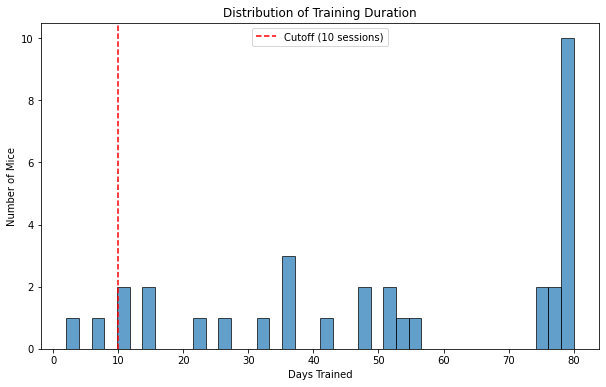

1726 sessions
608769 trials


In [8]:
# Get training duration stats
training_duration = sessions_training.groupby('mouse')['session'].max()
print(training_duration.describe())

plt.figure(figsize=(10, 6))
plt.hist(training_duration, bins=40, alpha=0.7, edgecolor='black')
plt.axvline(x=10, color='red', linestyle='--', label='Cutoff (10 sessions)')
plt.xlabel('Days Trained')
plt.ylabel('Number of Mice')
plt.title('Distribution of Training Duration')
plt.legend()
plt.show()

# Filter - FIXED VERSION
# Get mice with >= 10 sessions
valid_mice = training_duration[training_duration >= 10].index.tolist()
sessions_training_filtered1 = sessions_training[sessions_training['mouse'].isin(valid_mice)].reset_index(drop=True)
print(f'{len(sessions_training_filtered1)} sessions')
trials_training_filtered1 = trials_training[trials_training['mouse'].isin(valid_mice)].reset_index(drop=True)
print(f'{len(trials_training_filtered1)} trials')


### make wait df, 1 row per session

In [9]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [10]:
wait_df = generate_wait_df(sessions_training)

In [11]:
def print_tw_means(wait_df):
    print(f'{len(wait_df)} sessions')
    wait_df_short_mean = wait_df[wait_df['group'] == 's'].tw_mean.mean()
    print("Short tw mean: ", wait_df_short_mean)
    wait_df_long_mean = wait_df[wait_df['group'] == 'l'].tw_mean.mean()
    print("Long tw mean: ", wait_df_long_mean)
print_tw_means(wait_df)

1736 sessions
Short tw mean:  3.324228251479838
Long tw mean:  5.735816124762726


In [12]:
def generate_p_val_df(wait_df, group_col_name):
    """
    Generates a DataFrame with p-values and significance stars for t-tests 
    between two groups within each category.
    """
    result_list = []
    for num, data in wait_df.groupby(group_col_name):
        short = data[data['group']=='s']
        long = data[data['group']=='l']
        s_tw = short.tw_mean.mean()
        l_tw = long.tw_mean.mean()

        # Perform t-test
        ttest = stats.ttest_ind(short['tw_mean'], long['tw_mean'])
        p_val_t = ttest[1]

        # Determine significance stars
        stars = ""
        if p_val_t < 0.05:
            stars += "*"
        if p_val_t < 0.01:
            stars += "*"
        if p_val_t < 0.001:
            stars += "*"
        if p_val_t < 0.0001:
            stars += "*"

        result_list.append([num, s_tw, l_tw, p_val_t, stars])

    return pd.DataFrame(result_list, columns=["period", "s_tw", "l_tw", "p_val_t", "sig"])

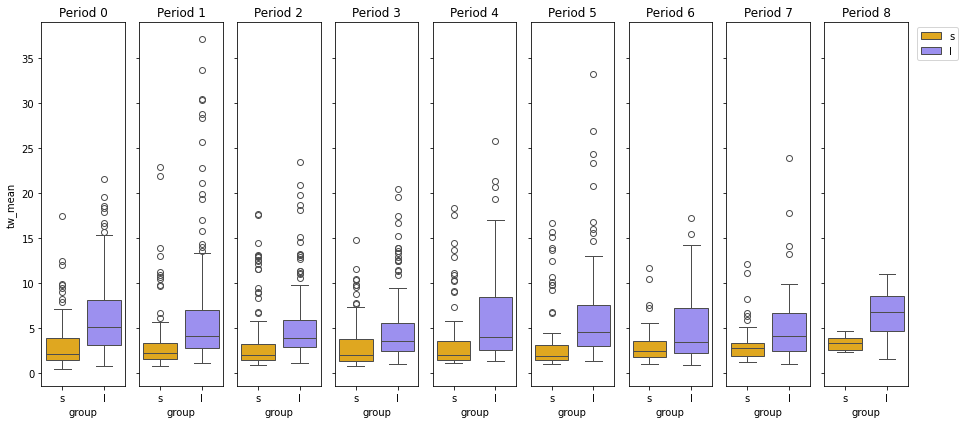

In [13]:
wait_df['period'] = wait_df['session']//10 #add session period in 10 day intervals
wait_df.loc[wait_df['period'] == 10, 'period'] = 9  # Change period 10 to period 9

num_subplots = wait_df['period'].max()+1
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*1.5, 6), sharey=True)

for i, (p, period_data) in enumerate(wait_df.groupby('period')):
    # Show legend only on the last subplot
    show_legend = (i == len(wait_df.groupby('period')) - 1)
    
    sns.boxplot(data=period_data,
                x="group", 
                y="tw_mean", 
                hue="group",
                palette=custom_palette,
                legend=show_legend,
                ax=axs.flat[p])
    
    # Add period labels
    axs.flat[p].set_title(f'Period {p}')
    if p != 0:
        axs.flat[p].set_ylabel("")
    
    # If this is the last subplot, adjust legend position
    if show_legend:
        axs.flat[p].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_box_by_period.png', bbox_inches='tight')

In [14]:
tw_stats_by_period = generate_p_val_df(wait_df, "period")
tw_stats_by_period['diff'] = tw_stats_by_period.l_tw - tw_stats_by_period.s_tw
tw_stats_by_period[tw_stats_by_period['p_val_t'] < 0.05]

,period,s_tw,l_tw,p_val_t,sig,diff
0,0,3.108316,6.173054,2.562026e-12,****,3.064738
1,1,3.245624,6.363418,2.113036e-06,****,3.117795
2,2,3.610690,5.224937,1.223566e-03,**,1.614248
3,3,3.066498,4.824068,1.335037e-04,***,1.757570
4,4,3.602424,6.267407,1.067745e-04,***,2.664983
5,5,3.881975,6.529915,2.610572e-03,**,2.647940
6,6,3.062239,4.910607,6.090590e-04,***,1.848368
7,7,3.126353,5.000239,1.412345e-03,**,1.873886


### outlier mice

In [15]:
def generate_mouse_wait_df(wait_df):
    data_list = []
    wait_df_by_mouse = wait_df.groupby('mouse')
    for m, mouse_data in wait_df_by_mouse:
        avg_avg_tw = mouse_data['tw_mean'].mean()
        data = {"mouse": m, 'tw': avg_avg_tw, 'group':mouse_data.group.tolist()[0]}
        data_list.append(data)
    mouse_wait_df = pd.DataFrame(data_list).sort_values(by=['group','tw'])
    return mouse_wait_df

In [16]:
mouse_wait_df = generate_mouse_wait_df(wait_df)
display(mouse_wait_df)

,mouse,tw,group
14,RZ056,3.087526,l
30,RZ075,3.459309,l
22,RZ065,3.764084,l
10,RZ052,3.946847,l
2,RZ037,4.117569,l
32,RZ078,4.221868,l
15,RZ057,4.465237,l
11,RZ053,4.580090,l
24,RZ067,4.753247,l
25,RZ068,4.977629,l


In [17]:
def find_outlier_mice(mouse_wait_df, method='iqr', multiplier=1.5):
    """
    Find outlier mice within each group based on tw values.
    """
    outlier_info = []
    
    for group in mouse_wait_df['group'].unique():
        group_data = mouse_wait_df[mouse_wait_df['group'] == group]
        
        if method == 'iqr':
            Q1 = group_data['tw'].quantile(0.25)
            Q3 = group_data['tw'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            outliers = group_data[
                (group_data['tw'] < lower_bound) | 
                (group_data['tw'] > upper_bound)
            ]
            
        elif method == 'zscore':
            mean_tw = group_data['tw'].mean()
            std_tw = group_data['tw'].std()
            z_scores = abs((group_data['tw'] - mean_tw) / std_tw)
            
            outliers = group_data[z_scores > multiplier]
        
        # Add outlier information
        for _, mouse in outliers.iterrows():
            outlier_info.append({
                'mouse': mouse['mouse'],
                'group': mouse['group'],
                'tw': mouse['tw'],
                'method': method,
                'is_outlier': True
            })
    
    return pd.DataFrame(outlier_info)

In [18]:
# Find outliers using IQR method
outliers_iqr = find_outlier_mice(mouse_wait_df, method='iqr', multiplier=1.5)
print("Outliers using IQR method (1.5x IQR):")
print(outliers_iqr)

# Find outliers using z-score method
outliers_zscore = find_outlier_mice(mouse_wait_df, method='zscore', multiplier=2.0)
print("\nOutliers using Z-score method (|z| > 2):")
print(outliers_zscore)

Outliers using IQR method (1.5x IQR):
   mouse group         tw method  is_outlier
0  RZ038     l  11.731679    iqr        True
1  RZ049     s   9.125444    iqr        True

Outliers using Z-score method (|z| > 2):
   mouse group         tw  method  is_outlier
0  RZ038     l  11.731679  zscore        True
1  RZ049     s   9.125444  zscore        True


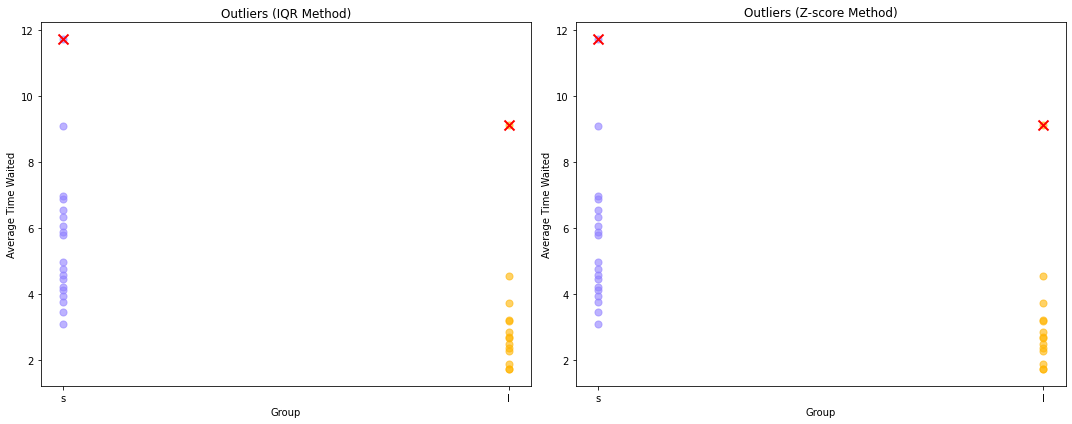

In [19]:
# Visualize outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot with IQR outliers highlighted
for group in mouse_wait_df['group'].unique():
    group_data = mouse_wait_df[mouse_wait_df['group'] == group]
    outlier_mice = outliers_iqr[outliers_iqr['group'] == group]['mouse'].tolist()
    
    # Plot all mice
    ax1.scatter([group] * len(group_data), group_data['tw'], 
               color=custom_palette[group], alpha=0.6, s=50)
    
    # Highlight outliers
    if outlier_mice:
        outlier_data = group_data[group_data['mouse'].isin(outlier_mice)]
        ax1.scatter([group] * len(outlier_data), outlier_data['tw'], 
                   color='red', s=100, marker='x', linewidth=2)

ax1.set_xlabel('Group')
ax1.set_ylabel('Average Time Waited')
ax1.set_title('Outliers (IQR Method)')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['s', 'l'])

# Plot with Z-score outliers highlighted
for group in mouse_wait_df['group'].unique():
    group_data = mouse_wait_df[mouse_wait_df['group'] == group]
    outlier_mice = outliers_zscore[outliers_zscore['group'] == group]['mouse'].tolist()
    
    # Plot all mice
    ax2.scatter([group] * len(group_data), group_data['tw'], 
               color=custom_palette[group], alpha=0.6, s=50)
    
    # Highlight outliers
    if outlier_mice:
        outlier_data = group_data[group_data['mouse'].isin(outlier_mice)]
        ax2.scatter([group] * len(outlier_data), outlier_data['tw'], 
                   color='red', s=100, marker='x', linewidth=2)

ax2.set_xlabel('Group')
ax2.set_ylabel('Average Time Waited')
ax2.set_title('Outliers (Z-score Method)')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['s', 'l'])

plt.tight_layout()
plt.show()

In [20]:
wait_df_no_outliers = wait_df[~wait_df['mouse'].isin(outliers_iqr['mouse'])]
print_tw_means(wait_df_no_outliers)

1576 sessions
Short tw mean:  2.653223795603472
Long tw mean:  5.191958500566766


In [21]:
wait_df_no_outliers

,mouse,session,dir,group,tw_mean,tw_median,tw_stdev,tw_mean_g,tw_median_g,tw_stdev_g,period
0,RZ034,0,2024-01-30_09-52-34_RZ034,s,0.466963,0.340259,0.435522,0.431781,0.310554,0.390514,0
1,RZ036,0,2024-01-30_09-55-23_RZ036,s,0.390074,0.302142,0.332347,0.378059,0.232625,0.395064,0
2,RZ037,0,2024-01-30_10-36-04_RZ037,l,1.696422,0.789636,2.564594,2.390402,1.037323,3.418212,0
4,RZ039,0,2024-01-30_11-40-20_RZ039,l,1.179677,0.509508,1.559682,2.174182,1.180063,1.941666,0
5,RZ034,1,2024-01-31_10-37-51_RZ034,s,2.898836,1.343189,6.223536,3.078756,1.523699,4.509924,0
...,...,...,...,...,...,...,...,...,...,...,...
1847,RZ077,10,2025-08-27_11-10-04_RZ077,l,3.317418,2.159722,5.217749,4.128626,2.919042,4.949848,1
1848,RZ078,10,2025-08-27_11-13-12_RZ078,l,4.913659,3.170819,6.796266,5.560225,4.089412,5.637177,1
1849,RZ075,14,2025-08-27_13-20-46_RZ075,l,1.642940,0.895945,2.049076,1.648606,0.907917,2.103500,1
1850,RZ077,11,2025-08-28_10-37-54_RZ077,l,6.536152,3.718458,8.845660,7.955799,6.276857,7.646000,1


<Axes: xlabel='group', ylabel='tw_mean'>

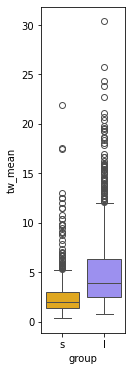

In [22]:
plt.figure(figsize=(1.5, 6))
sns.boxplot(data=wait_df_no_outliers, 
            x='group', 
            y='tw_mean',
            hue='group',
            palette=custom_palette,
            legend=False)

In [23]:
trials_training_filtered2 = trials_training[~trials_training['mouse'].isin(outliers_iqr['mouse'])]
print(f'{len(trials_training_filtered2)} trials')
tw_short = trials_training_filtered2[trials_training_filtered2['group'] == 's'].time_waited.mean()
print("Short tw mean: ", tw_short)
tw_long = trials_training_filtered2[trials_training_filtered2['group'] == 'l'].time_waited.mean()
print("Long tw mean: ", tw_long)

576181 trials
Short tw mean:  2.2540065053024247
Long tw mean:  4.332251942696235


In [57]:
trials_training_filtered2

,session_trial_num,block_trial_num,block_num,start_time,end_time,bg_drawn,bg_length,bg_repeats,num_bg_licks,miss_trial,...,dir,first_lick,second_lick,third_lick,fourth_lick,mouse,date,time,avg_tw,session
0,0.0,0.0,0.0,1.706626e+09,1.706626e+09,1.2,1.217297,2,1,False,...,2024-01-30_09-52-34_RZ034,0.009301,3.240196,4.723647,4.781255,RZ034,2024-01-30,09-52-34,0.47,0
1,1.0,1.0,0.0,1.706626e+09,1.706626e+09,1.2,7.525090,13,13,False,...,2024-01-30_09-52-34_RZ034,0.589926,0.678361,1.369078,1.479110,RZ034,2024-01-30,09-52-34,0.47,0
2,2.0,2.0,0.0,1.706626e+09,1.706626e+09,1.2,1.299892,2,1,False,...,2024-01-30_09-52-34_RZ034,0.093205,0.180445,1.796407,1.858674,RZ034,2024-01-30,09-52-34,0.47,0
3,3.0,3.0,0.0,1.706626e+09,1.706626e+09,1.0,1.026294,2,1,False,...,2024-01-30_09-52-34_RZ034,0.018922,0.152350,1.632616,1.717363,RZ034,2024-01-30,09-52-34,0.47,0
4,4.0,4.0,0.0,1.706626e+09,1.706626e+09,1.2,1.206799,1,0,False,...,2024-01-30_09-52-34_RZ034,1.753380,1.825397,2.540180,2.615595,RZ034,2024-01-30,09-52-34,0.47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652749,283.0,283.0,0.0,1.756396e+09,1.756396e+09,5.2,5.214659,1,0,False,...,2025-08-28_10-40-09_RZ078,13.178969,13.204785,13.335927,13.411730,RZ078,2025-08-28,10-40-09,3.43,11
652750,284.0,284.0,0.0,1.756396e+09,1.756396e+09,5.4,5.494098,2,1,False,...,2025-08-28_10-40-09_RZ078,0.055891,0.081490,8.179053,8.217253,RZ078,2025-08-28,10-40-09,3.43,11
652751,285.0,285.0,0.0,1.756396e+09,1.756396e+09,4.2,8.314914,4,3,False,...,2025-08-28_10-40-09_RZ078,3.664582,3.720727,3.835576,3.913357,RZ078,2025-08-28,10-40-09,3.43,11
652752,286.0,286.0,0.0,1.756396e+09,1.756396e+09,5.1,5.116718,1,0,False,...,2025-08-28_10-40-09_RZ078,5.222283,5.325878,5.416588,5.502170,RZ078,2025-08-28,10-40-09,3.43,11


In [ ]:
# Group by dir and calculate tw_mean for different trial types
def calculate_tw_means_by_dir(trials_data):
    results = []
    
    for dir_name, dir_data in trials_data.groupby('dir'):
        # All trials
        all_trials_mean = dir_data['time_waited'].mean()
        
       
        good_trials = dir_data[dir_data['good_trial'] == True]
        missed_trials = dir_data[dir_data['miss_trial'] == True]
         # Good trials only
        good_trials_mean = good_trials['time_waited'].mean() if len(good_trials) > 0 else None
        
        # No repeat trials only (bg_repeats == 1)
        no_repeat_trials = dir_data[dir_data['bg_repeats'] == 1]
        no_repeat_mean = no_repeat_trials['time_waited'].mean() if len(no_repeat_trials) > 0 else None
        
        # Get additional info
        mouse = dir_data['mouse'].iloc[0] if len(dir_data) > 0 else None
        group = dir_data['group'].iloc[0] if len(dir_data) > 0 else None
        session = dir_data['session'].iloc[0] if len(dir_data) > 0 else None
        
        results.append({
            'dir': dir_name,
            'mouse': mouse,
            'group': group,
            'session': session,
            'total_trials': len(dir_data),
            'good_trials_count': len(good_trials),
            'missed_trials_count': len(missed_trials),
            'no_repeat_trials_count': len(no_repeat_trials),
            'tw_mean_all_trials': all_trials_mean,
            'tw_mean_good_trials': good_trials_mean,
            'tw_mean_no_repeat_trials': no_repeat_mean
        })
    
    return pd.DataFrame(results)

# Calculate the means
tw_means_by_dir = calculate_tw_means_by_dir(trials_training_filtered2)
print(f"Calculated tw_means for {len(tw_means_by_dir)} sessions")
display(tw_means_by_dir)

Calculated tw_means for 1576 sessions


,dir,mouse,group,session,total_trials,good_trials_count,missed_trials_count,no_repeat_trials_count,tw_mean_all_trials,tw_mean_good_trials,tw_mean_no_repeat_trials
0,2024-01-30_09-52-34_RZ034,RZ034,s,0,397,64,0,64,0.466963,0.431781,0.431781
1,2024-01-30_09-55-23_RZ036,RZ036,s,0,664,123,0,123,0.390074,0.378059,0.378059
2,2024-01-30_10-36-04_RZ037,RZ037,l,0,252,60,0,60,1.696422,2.390402,2.390402
3,2024-01-30_11-40-20_RZ039,RZ039,l,0,245,15,0,15,1.179677,2.174182,2.174182
4,2024-01-31_10-37-51_RZ034,RZ034,s,1,510,286,4,290,2.898836,3.078756,3.863877
...,...,...,...,...,...,...,...,...,...,...,...
1571,2025-08-27_11-10-04_RZ077,RZ077,l,10,234,98,1,99,3.317418,4.128626,4.692983
1572,2025-08-27_11-13-12_RZ078,RZ078,l,10,254,136,2,138,4.913659,5.560225,6.349207
1573,2025-08-27_13-20-46_RZ075,RZ075,l,14,586,231,0,231,1.642940,1.648606,1.648606
1574,2025-08-28_10-37-54_RZ077,RZ077,l,11,185,97,2,99,6.536152,7.955799,9.007197


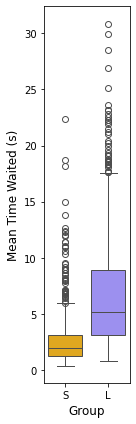

In [26]:
# Create boxplot for no repeat trials with proper labels and save
plt.figure(figsize=(2, 6))
sns.boxplot(data=tw_means_by_dir, 
            x='group', 
            y='tw_mean_no_repeat_trials',
            hue='group',
            palette=custom_palette,
            legend=False)

# Add appropriate labels
plt.xlabel('Group', fontsize=12)
plt.ylabel('Mean Time Waited (s)', fontsize=12)

# Set x-axis labels
plt.xticks([0, 1], ['S', 'L'], fontsize=10)

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_boxplot_no_repeat_trials.png', dpi=300, bbox_inches='tight')

In [27]:
trials_training_filtered2_good = trials_training_filtered2[trials_training_filtered2['good_trial'] == True]
print(f'{len(trials_training_filtered2_good)} good trials')
tw_short = trials_training_filtered2_good[trials_training_filtered2_good['group'] == 's'].time_waited.mean()
print("Short tw mean: ", tw_short)
tw_long = trials_training_filtered2_good[trials_training_filtered2_good['group'] == 'l'].time_waited.mean()
print("Long tw mean: ", tw_long)

296580 good trials
Short tw mean:  2.3446284710857985
Long tw mean:  4.488622210851122


In [28]:
trials_training_filtered2_no_repeat = trials_training_filtered2[trials_training_filtered2['bg_repeats'] == 1]
print(f'{len(trials_training_filtered2_no_repeat)} no repeat trials')
tw_short = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 's'].time_waited.mean()
print("Short tw mean: ", tw_short)
tw_long = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 'l'].time_waited.mean()
print("Long tw mean: ", tw_long)

301635 no repeat trials
Short tw mean:  2.61398788978691
Long tw mean:  6.066293065777719


In [29]:
# Statistical comparison between groups (no repeat trials)
short_tw = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 's']['time_waited']
long_tw = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 'l']['time_waited']

# Perform t-test
t_stat, p_value = stats.ttest_ind(short_tw, long_tw)

# Print results
print("Statistical Comparison (No Repeat Trials):")
print(f"Short group: n={len(short_tw)}, mean={short_tw.mean():.3f}±{short_tw.std():.3f}s")
print(f"Long group: n={len(long_tw)}, mean={long_tw.mean():.3f}±{long_tw.std():.3f}s")
print(f"T-test: t={t_stat:.3f}")
print(f"Mean difference: {long_tw.mean() - short_tw.mean():.3f}s")

# Effect size
cohens_d = (long_tw.mean() - short_tw.mean()) / np.sqrt((short_tw.var() + long_tw.var()) / 2)
print(f"Effect size (Cohen's d): {cohens_d:.3f}")

Statistical Comparison (No Repeat Trials):
Short group: n=148120, mean=2.614±5.546s
Long group: n=153515, mean=6.066±11.723s
T-test: t=-102.783
Mean difference: 3.452s
Effect size (Cohen's d): 0.376


In [30]:
# Add period information to tw_means_by_dir based on sessions_training
# First, get the period mapping from sessions_training
period_mapping = wait_df[['dir', 'period']].set_index('dir')['period'].to_dict()

# Add period column to tw_means_by_dir
tw_means_by_dir['period'] = tw_means_by_dir['dir'].map(period_mapping)

# Group by period and calculate mean and standard error for each group
period_stats = tw_means_by_dir.groupby(['period', 'group']).agg({
    'tw_mean_no_repeat_trials': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
period_stats.columns = ['period', 'group', 'mean_tw', 'std_tw', 'count']

# Calculate standard error
period_stats['se_tw'] = period_stats['std_tw'] / np.sqrt(period_stats['count'])

# Display the period statistics
print("Period Statistics:")
display(period_stats)

Period Statistics:


,period,group,mean_tw,std_tw,count,se_tw
0,0,l,9.091478,5.651766,173,0.429696
1,0,s,3.441837,3.167256,127,0.281049
2,1,l,6.633677,4.807436,145,0.399236
3,1,s,2.624921,2.594972,120,0.236887
4,2,l,5.963332,3.978063,130,0.348899
5,2,s,2.867829,2.945724,110,0.280864
6,3,l,5.304095,3.671869,126,0.327116
7,3,s,2.378645,1.845047,92,0.192359
8,4,l,7.034821,5.641514,102,0.558593
9,4,s,2.496782,1.998557,76,0.229250


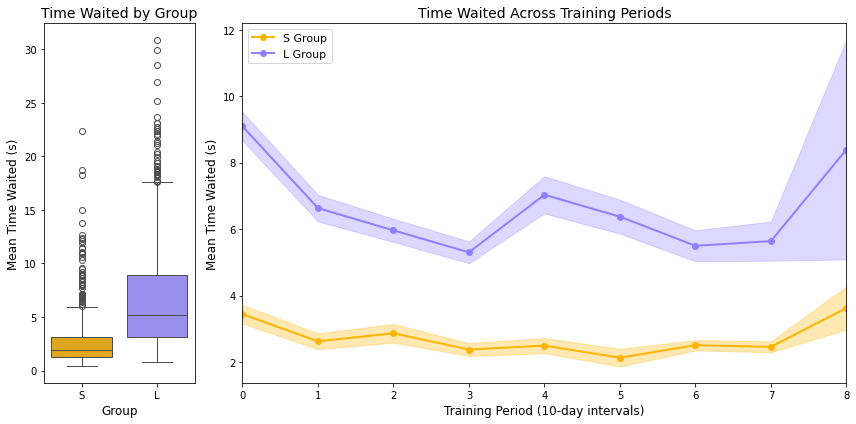

In [32]:
# Create combined plot with 1:3 ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 4]})

# Left plot: Boxplot by group
sns.boxplot(data=tw_means_by_dir, 
            x='group', 
            y='tw_mean_no_repeat_trials',
            hue='group',
            palette=custom_palette,
            legend=False,
            ax=ax1)

ax1.set_xlabel('Group', fontsize=12)
ax1.set_ylabel('Mean Time Waited (s)', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['S', 'L'], fontsize=10)
ax1.set_title('Time Waited by Group', fontsize=14)

# Right plot: Line plot by period
for group in ['s', 'l']:
    group_data = period_stats[period_stats['group'] == group]
    
    # Plot line
    ax2.plot(group_data['period'], group_data['mean_tw'], 
             marker='o', linewidth=2, markersize=6, 
             color=custom_palette[group], label=f'{group.upper()} Group')
    
    # Add error shading (standard error)
    ax2.fill_between(group_data['period'], 
                     group_data['mean_tw'] - group_data['se_tw'],
                     group_data['mean_tw'] + group_data['se_tw'],
                     alpha=0.3, color=custom_palette[group])

ax2.set_xlabel('Training Period (10-day intervals)', fontsize=12)
ax2.set_ylabel('Mean Time Waited (s)', fontsize=12)
ax2.set_title('Time Waited Across Training Periods', fontsize=14)
ax2.legend(fontsize=11)
ax2.set_xlim(0, 8)
ax2.set_xticks(range(int(period_stats['period'].min()), int(period_stats['period'].max()) + 1))

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_combined_plot_1_4_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Get number of mice by group
mice_by_group = trials_training_filtered2.groupby('group')['mouse'].nunique()
print("Number of mice by group:")
print(mice_by_group)

# Get count of trials for each group
trials_by_group = trials_training_filtered2_no_repeat.groupby('group').size()
print("Number of trials by group:")
print(trials_by_group)


Number of mice by group:
group
l    18
s    13
Name: mouse, dtype: int64
Number of trials by group:
group
l    153515
s    148120
dtype: int64


In [35]:
tw_mean_by_dir_to_plot = tw_means_by_dir.copy()
tw_mean_by_dir_to_plot['p_missed'] = tw_mean_by_dir_to_plot['missed_trials_count'] / tw_mean_by_dir_to_plot['total_trials']
tw_mean_by_dir_to_plot['p_good'] = tw_mean_by_dir_to_plot['good_trials_count'] / tw_mean_by_dir_to_plot['total_trials']

In [56]:
tw_mean_by_dir_to_plot

,dir,mouse,group,session,total_trials,good_trials_count,missed_trials_count,no_repeat_trials_count,tw_mean_all_trials,tw_mean_good_trials,tw_mean_no_repeat_trials,period,p_missed,p_good
0,2024-01-30_09-52-34_RZ034,RZ034,s,0,397,64,0,64,0.466963,0.431781,0.431781,0,0.000000,0.161209
1,2024-01-30_09-55-23_RZ036,RZ036,s,0,664,123,0,123,0.390074,0.378059,0.378059,0,0.000000,0.185241
2,2024-01-30_10-36-04_RZ037,RZ037,l,0,252,60,0,60,1.696422,2.390402,2.390402,0,0.000000,0.238095
3,2024-01-30_11-40-20_RZ039,RZ039,l,0,245,15,0,15,1.179677,2.174182,2.174182,0,0.000000,0.061224
4,2024-01-31_10-37-51_RZ034,RZ034,s,1,510,286,4,290,2.898836,3.078756,3.863877,0,0.007843,0.560784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,2025-08-27_11-10-04_RZ077,RZ077,l,10,234,98,1,99,3.317418,4.128626,4.692983,1,0.004274,0.418803
1572,2025-08-27_11-13-12_RZ078,RZ078,l,10,254,136,2,138,4.913659,5.560225,6.349207,1,0.007874,0.535433
1573,2025-08-27_13-20-46_RZ075,RZ075,l,14,586,231,0,231,1.642940,1.648606,1.648606,1,0.000000,0.394198
1574,2025-08-28_10-37-54_RZ077,RZ077,l,11,185,97,2,99,6.536152,7.955799,9.007197,1,0.010811,0.524324


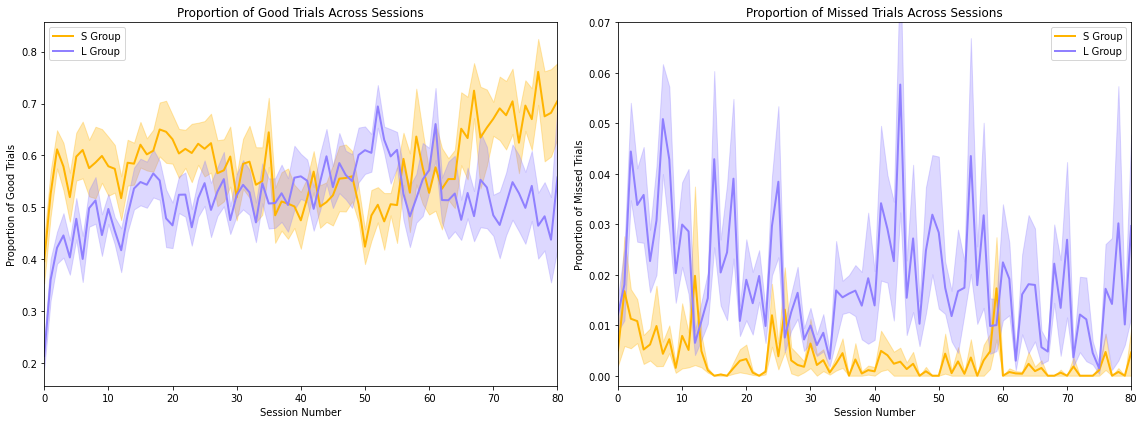

Mean Trial Proportions by Group:
      p_good_mean        p_missed_mean       
             mean    std          mean    std
group                                        
l           0.517  0.066         0.020  0.012
s           0.582  0.070         0.003  0.004


In [49]:
# Calculate mean and standard error by group and session
trial_prop_stats = tw_mean_by_dir_to_plot.groupby(['group', 'session']).agg({
    'p_good': ['mean', 'std', 'count'],
    'p_missed': ['mean', 'std', 'count']
}).reset_index()

trial_prop_stats.columns = ['group', 'session', 'p_good_mean', 'p_good_std', 'p_good_count', 
                           'p_missed_mean', 'p_missed_std', 'p_missed_count']

# Calculate standard error
trial_prop_stats['p_good_se'] = trial_prop_stats['p_good_std'] / np.sqrt(trial_prop_stats['p_good_count'])
trial_prop_stats['p_missed_se'] = trial_prop_stats['p_missed_std'] / np.sqrt(trial_prop_stats['p_missed_count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Good trials
for group in ['s', 'l']:
    group_data = trial_prop_stats[trial_prop_stats['group'] == group]
    
    # Plot line
    ax1.plot(group_data['session'], group_data['p_good_mean'], linewidth=2,
             color=custom_palette[group], 
             label=f'{group.upper()} Group')
    
    # Add error shading
    ax1.fill_between(group_data['session'], 
                     group_data['p_good_mean'] - group_data['p_good_se'],
                     group_data['p_good_mean'] + group_data['p_good_se'],
                     alpha=0.3, color=custom_palette[group])

ax1.set_title('Proportion of Good Trials Across Sessions')
ax1.set_xlabel('Session Number')
ax1.set_xlim(0, 80)
ax1.set_ylabel('Proportion of Good Trials')
ax1.legend()

# Right subplot: Missed trials
for group in ['s', 'l']:
    group_data = trial_prop_stats[trial_prop_stats['group'] == group]

    ax2.plot(group_data['session'], group_data['p_missed_mean'], linewidth=2,
             color=custom_palette[group], 
             label=f'{group.upper()} Group')
    
    # Add error shading
    ax2.fill_between(group_data['session'], 
                     group_data['p_missed_mean'] - group_data['p_missed_se'],
                     group_data['p_missed_mean'] + group_data['p_missed_se'],
                     alpha=0.3, color=custom_palette[group])

ax2.set_title('Proportion of Missed Trials Across Sessions')
ax2.set_xlabel('Session Number')
ax2.set_xlim(0, 80)
ax2.set_ylabel('Proportion of Missed Trials')
ax2.set_ylim(-0.002, 0.07)
ax2.legend()

plt.tight_layout()
plt.savefig(f'{figure_folder}/p_good_vs_missed_subplots_shading.png', dpi=300, bbox_inches='tight')
plt.show()

# Display summary statistics
print("Mean Trial Proportions by Group:")
summary = trial_prop_stats.groupby('group')[['p_good_mean', 'p_missed_mean']].agg(['mean', 'std']).round(3)
print(summary)


In [ ]:
trials_training_filtered2_no_repeat['group_numeric'] = (trials_training_filtered2_no_repeat['group'] == 'l').astype(int)

# Fit the LMEM
model = smf.mixedlm(
    "time_waited ~ group_numeric * session + group_numeric * I(session**2) + session_trial_num",
    data=trials_training_filtered2_no_repeat,
    groups=trials_training_filtered2_no_repeat["mouse"]
)
result = model.fit()

print(result.summary())

/var/folders/fv/h96g2bdx42l2htl2pxpvr84h0000gn/T/ipykernel_33914/2395998492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_training_filtered2_no_repeat['group_numeric'] = (trials_training_filtered2_no_repeat['group'] == 'l').astype(int)


                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     time_waited  
No. Observations:       316139      Method:                 REML         
No. Groups:             30          Scale:                  79.7161      
Min. group size:        344         Log-Likelihood:         -1140801.7917
Max. group size:        22659       Converged:              Yes          
Mean group size:        10538.0                                          
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      1.936    0.467   4.145 0.000  1.021  2.852
group_numeric                  5.590    0.604   9.255 0.000  4.406  6.774
session                       -0.046    0.003 -14.335 0.000 -0.052 -0.040
group_numeric:session         -0.081    0.005 -16.297 0.

### LMEM

In [ ]:
trials_training_filtered2_no_repeat.keys()

In [ ]:
# Create an explicit copy of the DataFrame to avoid the warning
lmem_data = trials_training_filtered2_no_repeat.copy()

# Now, you can safely add the new column to the copy
lmem_data['group_numeric'] = (lmem_data['group'] == 'l').astype(int)

# Fit the LMEM
model = smf.mixedlm(
    "time_waited ~ group_numeric * session + group_numeric * I(session**2) + session_trial_num",
    data=lmem_data,
    groups=lmem_data["mouse"]
)
result = model.fit()

print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     time_waited  
No. Observations:       301635      Method:                 REML         
No. Groups:             31          Scale:                  82.2803      
Min. group size:        344         Log-Likelihood:         -1093245.5046
Max. group size:        20121       Converged:              Yes          
Mean group size:        9730.2                                           
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      2.195    0.465   4.720 0.000  1.284  3.107
group_numeric                  5.542    0.611   9.064 0.000  4.344  6.741
session                       -0.059    0.004 -14.926 0.000 -0.067 -0.052
group_numeric:session         -0.099    0.006 -16.567 0.

Session Statistics:


,session,group,mean_tw,std_tw,count,se_tw
0,0,l,4.885423,2.638874,18,0.621989
1,0,s,2.077796,2.007372,13,0.556745
2,1,l,5.466456,3.860540,18,0.909938
3,1,s,3.903267,3.911395,13,1.084826
4,2,l,7.917596,5.272351,18,1.242705
...,...,...,...,...,...,...
157,78,s,2.569544,1.051785,5,0.470373
158,79,l,5.226870,3.266818,4,1.633409
159,79,s,2.272149,0.911089,5,0.407451
160,80,l,6.752082,4.848175,3,2.799095


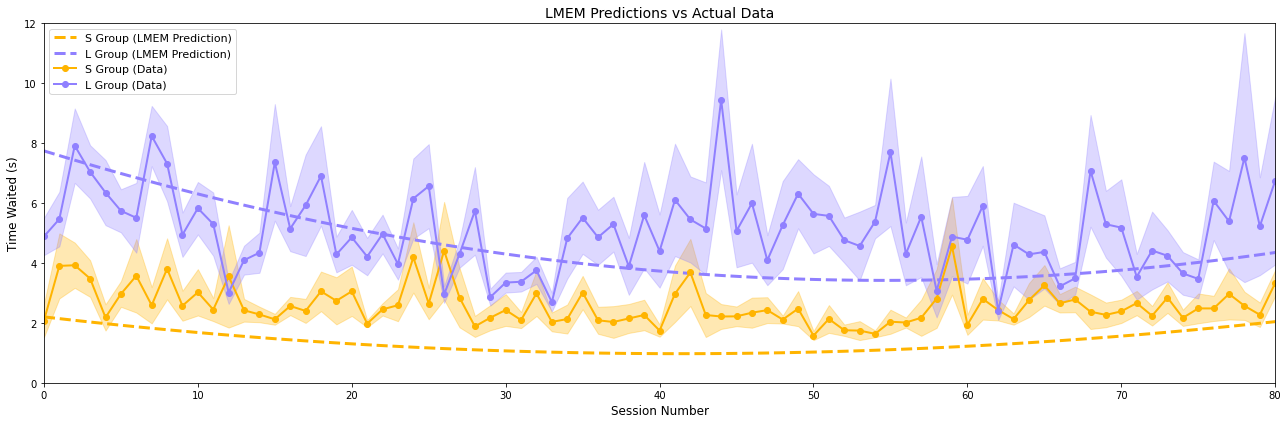

In [55]:
# Create a DataFrame to hold predicted values for the overall trend
sessions_to_predict = np.linspace(lmem_data['session'].min(), lmem_data['session'].max(), 100)
pred_df = pd.DataFrame({
    'session': np.tile(sessions_to_predict, 2),
    'group': np.repeat(['l', 's'], len(sessions_to_predict)),
    'session_trial_num': 1, # Set to a constant value, e.g., the first trial
    'mouse': lmem_data['mouse'].iloc[0] # A dummy mouse ID
})
pred_df['group_numeric'] = (pred_df['group'] == 'l').astype(int)
pred_df['time_waited'] = result.predict(pred_df)

# Group by session and calculate mean and standard error for each group
session_stats = tw_means_by_dir.groupby(['session', 'group']).agg({
    'tw_mean_all_trials': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
session_stats.columns = ['session', 'group', 'mean_tw', 'std_tw', 'count']

# Calculate standard error
session_stats['se_tw'] = session_stats['std_tw'] / np.sqrt(session_stats['count'])

# Create combined plot
plt.figure(figsize=(18, 6))

# Plot LMEM predictions as dashed lines
for group in ['s', 'l']:
    group_pred = pred_df[pred_df['group'] == group]
    plt.plot(group_pred['session'], group_pred['time_waited'], 
             linestyle='--', linewidth=3,
             color=custom_palette[group], 
             label=f'{group.upper()} Group (LMEM Prediction)')

# Plot actual data with error shading
for group in ['s', 'l']:
    group_data = session_stats[session_stats['group'] == group]
    
    # Plot line
    plt.plot(group_data['session'], group_data['mean_tw'], 
             marker='o', markersize=6, linewidth=2,
             color=custom_palette[group], 
             label=f'{group.upper()} Group (Data)')
    
    # Add error shading
    plt.fill_between(group_data['session'], 
                     group_data['mean_tw'] - group_data['se_tw'],
                     group_data['mean_tw'] + group_data['se_tw'],
                     alpha=0.3, color=custom_palette[group])

plt.title('LMEM Predictions vs Actual Data', fontsize=14)
plt.xlabel('Session Number', fontsize=12)
plt.ylabel('Time Waited (s)', fontsize=12)
plt.legend(fontsize=11)
plt.xlim(0, 80)
plt.ylim(0, 12)
plt.tight_layout()
plt.savefig(f'{figure_folder}/combined_lmem_and_data.png', dpi=300, bbox_inches='tight')
# plt.show()

# Display the session statistics
print("Session Statistics:")
display(session_stats)


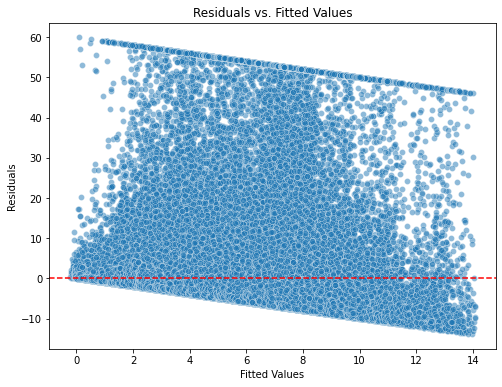

In [58]:

fitted_values = result.fittedvalues
residuals = result.resid

# Create a scatter plot of residuals vs. fitted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

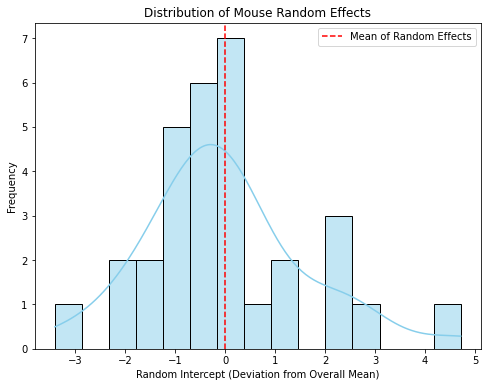

In [59]:
# Assuming 'result' is the result object from your LMEM fitting
# And 'lmem_data' is your original DataFrame

# Get the random effects from your model
random_effects = result.random_effects
mouse_intercepts = [random_effects[mouse][0] for mouse in lmem_data['mouse'].unique()]

# Create a histogram of the random effects
plt.figure(figsize=(8, 6))
sns.histplot(mouse_intercepts, bins=15, kde=True, color='skyblue', edgecolor='black')
plt.axvline(x=np.mean(mouse_intercepts), color='red', linestyle='--', label='Mean of Random Effects')
plt.xlabel('Random Intercept (Deviation from Overall Mean)')
plt.ylabel('Frequency')
plt.title('Distribution of Mouse Random Effects')
plt.legend()
plt.show()

In [ ]:
# Linear Mixed Effects Model
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Prepare data for LMEM
lmem_data = trials_training_filtered2_no_repeat.copy()

# Create dummy variable for group (0 = short, 1 = long)
lmem_data['group_numeric'] = (lmem_data['group'] == 'l').astype(int)

# Fit Linear Mixed Effects Model
# Fixed effects: group, random effects: mouse (to account for within-mouse correlation)
model = mixedlm("time_waited ~ group_numeric", lmem_data, groups=lmem_data["mouse"])
result = model.fit()

# Print results
print("Linear Mixed Effects Model Results:")
print("=" * 50)
print(result.summary())

# Extract key statistics
print(f"\nKey Results:")
print(f"Group effect (Long vs Short): {result.params['group_numeric']:.4f}")
print(f"Standard error: {result.bse['group_numeric']:.4f}")
print(f"t-statistic: {result.tvalues['group_numeric']:.4f}")
print(f"p-value: {result.pvalues['group_numeric']:.4f}")

# Confidence interval
ci = result.conf_int()
print(f"95% CI: [{ci.loc['group_numeric', 0]:.4f}, {ci.loc['group_numeric', 1]:.4f}]")

# Random effects variance
print(f"\nRandom Effects:")
print(f"Mouse variance: {result.cov_re.iloc[0,0]:.4f}")
print(f"Residual variance: {result.scale:.4f}")
print(f"ICC (Intraclass Correlation): {result.cov_re.iloc[0,0] / (result.cov_re.iloc[0,0] + result.scale):.4f}")

In [ ]:
# 1. Residual plots for model diagnostics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Fitted vs residuals
fitted_values = result.fittedvalues
residuals = result.resid
axes[0,0].scatter(fitted_values, residuals, alpha=0.5)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted')

# Q-Q plot for normality
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (Normality Check)')

# Residuals by group
group_residuals = [residuals[lmem_data['group'] == g] for g in ['s', 'l']]
axes[1,0].boxplot(group_residuals, labels=['Short', 'Long'])
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residuals by Group')

# Histogram of residuals
axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.savefig(f'{figure_folder}/lmem_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Random effects (mouse-level intercepts)
random_effects = result.random_effects
mouse_intercepts = [random_effects[mouse] for mouse in lmem_data['mouse'].unique()]

plt.figure(figsize=(10, 6))
plt.hist(mouse_intercepts, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Random Intercept (Mouse Effect)')
plt.ylabel('Number of Mice')
plt.title('Distribution of Mouse Random Effects')
plt.axvline(x=0, color='red', linestyle='--', label='Population Mean')
plt.legend()
plt.tight_layout()
plt.savefig(f'{figure_folder}/lmem_random_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Model predictions vs observed
plt.figure(figsize=(8, 6))
plt.scatter(lmem_data['time_waited'], fitted_values, alpha=0.5)
plt.plot([lmem_data['time_waited'].min(), lmem_data['time_waited'].max()], 
         [lmem_data['time_waited'].min(), lmem_data['time_waited'].max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('Observed Time Waited')
plt.ylabel('Predicted Time Waited')
plt.title('Model Predictions vs Observed Values')
plt.legend()
plt.tight_layout()
plt.savefig(f'{figure_folder}/lmem_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Effect size visualization
plt.figure(figsize=(8, 6))
group_effect = result.params['group_numeric']
ci_lower = result.conf_int().loc['group_numeric', 0]
ci_upper = result.conf_int().loc['group_numeric', 1]

plt.errorbar(0, group_effect, yerr=[[group_effect - ci_lower], [ci_upper - group_effect]], 
             fmt='o', capsize=10, capthick=2, markersize=10, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlim(-0.5, 0.5)
plt.xticks([0], ['Group Effect\n(Long vs Short)'])
plt.ylabel('Effect Size (seconds)')
plt.title('LMEM Group Effect with 95% Confidence Interval')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{figure_folder}/lmem_effect_size.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Model comparison: LMEM vs regular regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Regular regression (ignoring mouse clustering)
X = lmem_data[['group_numeric']]
y = lmem_data['time_waited']
reg = LinearRegression().fit(X, y)
reg_pred = reg.predict(X)

# Compare R²
lmem_r2 = 1 - (result.resid**2).sum() / ((y - y.mean())**2).sum()
reg_r2 = r2_score(y, reg_pred)

print(f"Model Comparison:")
print(f"LMEM R²: {lmem_r2:.4f}")
print(f"Regular Regression R²: {reg_r2:.4f}")
print(f"Improvement: {lmem_r2 - reg_r2:.4f}")

# 6. Mouse-level predictions
mouse_predictions = lmem_data.groupby('mouse').agg({
    'time_waited': 'mean',
    'group': 'first'
}).reset_index()

# Add model predictions for each mouse
mouse_predictions['predicted'] = mouse_predictions.apply(
    lambda row: result.params['Intercept'] + 
                result.params['group_numeric'] * (1 if row['group'] == 'l' else 0) +
                random_effects[row['mouse']], axis=1
)

plt.figure(figsize=(12, 6))
colors = [custom_palette['s'] if g == 's' else custom_palette['l'] 
          for g in mouse_predictions['group']]
plt.scatter(mouse_predictions['time_waited'], mouse_predictions['predicted'], 
           c=colors, alpha=0.7, s=60)
plt.plot([mouse_predictions['time_waited'].min(), mouse_predictions['time_waited'].max()], 
         [mouse_predictions['time_waited'].min(), mouse_predictions['time_waited'].max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('Observed Mean Time Waited (per mouse)')
plt.ylabel('Predicted Mean Time Waited (per mouse)')
plt.title('Mouse-Level Predictions')
plt.legend()
plt.tight_layout()
plt.savefig(f'{figure_folder}/lmem_mouse_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming df_clean is your cleaned DataFrame and model_fit is your fitted model
# This is dummy data and model for demonstration purposes.
# Replace with your actual data and fitted model.

model = smf.mixedlm("time_waited ~ C(group) * session", data=trials_training_filtered2_no_repeat, groups=trials_training_filtered2_no_repeat['mouse'])
model_fit = model.fit()

plt.figure(figsize=(12, 8))

# Plot individual mouse trajectories
sns.lineplot(data=trials_training_filtered2_no_repeat, x='session', y='time_waited', hue='group', units='mouse',
             estimator=None, alpha=0.3, linewidth=1, palette=two_colors)

# Create a DataFrame for predictions to plot the main trend lines
sessions_to_predict = np.linspace(trials_training_filtered2_no_repeat['session'].min(), trials_training_filtered2_no_repeat['session'].max(), 100)
pred_df = pd.DataFrame({
    'session': np.tile(sessions_to_predict, 2),
    'group': np.repeat(['long', 'short'], len(sessions_to_predict))
})
pred_df['predicted_tw'] = model_fit.predict(pred_df)

# Plot the overall group trend
sns.lineplot(data=pred_df, x='session', y='predicted_tw', hue='group',
             linewidth=3, palette=two_colors, style=True, markers=False)

plt.title('Individual and Overall Group Learning Trajectories')
plt.xlabel('Session Number')
plt.ylabel('Time Waited (s)')
plt.legend()
plt.show()

In [ ]:
# Assuming lmem_data is your cleaned DataFrame and 'group' and 'mouse' columns exist
# Create a dummy variable for group (0 = short, 1 = long)
lmem_data['group_numeric'] = (lmem_data['group'] == 'long').astype(int)

# Add a session number to the data if it's not already there
# This assumes 'session' is the original column name for training days
lmem_data['session_num'] = lmem_data.groupby('mouse')['session'].transform(lambda x: pd.factorize(x)[0] + 1)

# Fit the Linear Mixed Effects Model with learning effects
# The formula now includes linear and quadratic session terms and their interactions with the group
model = smf.mixedlm(
    "time_waited ~ group_numeric * session_num + group_numeric * I(session_num**2)",
    data=lmem_data,
    groups=lmem_data["mouse"]
)
result = model.fit()

# Print the model summary
print(result.summary())

### outlier sessions

In [ ]:
def find_outlier_sessions_per_mouse(wait_df, method='iqr', multiplier=1.5):
    """
    Find outlier sessions within each mouse based on tw_mean values.
    
    Parameters:
    -----------
    wait_df : pd.DataFrame
        DataFrame with columns including 'mouse', 'session', 'tw_mean'
    method : str, default='iqr'
        Method to use: 'iqr' or 'zscore'
    multiplier : float, default=1.5
        For IQR method: multiplier for IQR bounds
        For zscore method: z-score threshold
    
    Returns:
    --------
    pd.DataFrame : DataFrame with outlier session information
    """
    outlier_sessions = []
    
    for mouse in wait_df['mouse'].unique():
        mouse_data = wait_df[wait_df['mouse'] == mouse].copy()
        
        if len(mouse_data) < 3:  # Need at least 3 sessions to detect outliers
            continue
            
        if method == 'iqr':
            Q1 = mouse_data['tw_mean'].quantile(0.25)
            Q3 = mouse_data['tw_mean'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            outliers = mouse_data[
                (mouse_data['tw_mean'] < lower_bound) | 
                (mouse_data['tw_mean'] > upper_bound)
            ]
            
        elif method == 'zscore':
            mean_tw = mouse_data['tw_mean'].mean()
            std_tw = mouse_data['tw_mean'].std()
            z_scores = abs((mouse_data['tw_mean'] - mean_tw) / std_tw)
            
            outliers = mouse_data[z_scores > multiplier]
        
        # Add outlier information
        for _, session in outliers.iterrows():
            outlier_sessions.append({
                'mouse': session['mouse'],
                'session': session['session'],
                'tw_mean': session['tw_mean'],
                'group': session['group'],
                'period': session['period'],
                'method': method,
                'is_outlier': True
            })
    
    return pd.DataFrame(outlier_sessions)

# Find outlier sessions using IQR method
outlier_sessions_iqr = find_outlier_sessions_per_mouse(wait_df, method='iqr', multiplier=1.5)
print("Outlier sessions using IQR method (1.5x IQR):")
print(outlier_sessions_iqr)

# Find outlier sessions using z-score method
outlier_sessions_zscore = find_outlier_sessions_per_mouse(wait_df, method='zscore', multiplier=2.0)
print("\nOutlier sessions using Z-score method (|z| > 2):")
print(outlier_sessions_zscore)

# Summary statistics
print(f"\nSummary:")
print(f"Total sessions: {len(wait_df)}")
print(f"Outlier sessions (IQR): {len(outlier_sessions_iqr)} ({len(outlier_sessions_iqr)/len(wait_df)*100:.1f}%)")
print(f"Outlier sessions (Z-score): {len(outlier_sessions_zscore)} ({len(outlier_sessions_zscore)/len(wait_df)*100:.1f}%)")

In [ ]:
# Separate mice by group for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Get outlier sessions
outlier_sessions_iqr = find_outlier_sessions_per_mouse(wait_df, method='iqr', multiplier=1.5)

# Plot Short group mice
short_mice = wait_df[wait_df['group'] == 's']['mouse'].unique()
for mouse in sorted(short_mice):
    mouse_data = wait_df[wait_df['mouse'] == mouse].sort_values('session')
    outlier_sessions = outlier_sessions_iqr[outlier_sessions_iqr['mouse'] == mouse]
    
    # Plot all sessions
    ax1.plot(mouse_data['session'], mouse_data['tw_mean'], 
             'o-', alpha=0.7, markersize=4, linewidth=1, label=f'{mouse}')
    
    # Highlight outlier sessions
    if len(outlier_sessions) > 0:
        outlier_data = mouse_data[mouse_data['session'].isin(outlier_sessions['session'])]
        ax1.scatter(outlier_data['session'], outlier_data['tw_mean'], 
                   color='red', s=50, marker='x', linewidth=2, zorder=5)

ax1.set_title('Short Group Mice', fontsize=14)
ax1.set_xlabel('Session')
ax1.set_ylabel('TW Mean')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Plot Long group mice
long_mice = wait_df[wait_df['group'] == 'l']['mouse'].unique()
for mouse in sorted(long_mice):
    mouse_data = wait_df[wait_df['mouse'] == mouse].sort_values('session')
    outlier_sessions = outlier_sessions_iqr[outlier_sessions_iqr['mouse'] == mouse]
    
    # Plot all sessions
    ax2.plot(mouse_data['session'], mouse_data['tw_mean'], 
             'o-', alpha=0.7, markersize=4, linewidth=1, label=f'{mouse}')
    
    # Highlight outlier sessions
    if len(outlier_sessions) > 0:
        outlier_data = mouse_data[mouse_data['session'].isin(outlier_sessions['session'])]
        ax2.scatter(outlier_data['session'], outlier_data['tw_mean'], 
                   color='red', s=50, marker='x', linewidth=2, zorder=5)

ax2.set_title('Long Group Mice', fontsize=14)
ax2.set_xlabel('Session')
ax2.set_ylabel('TW Mean')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
wait_df_no_outlier_sessions_iqr = wait_df[~wait_df['session'].isin(outlier_sessions_iqr['session'])]
print_tw_means(wait_df_no_outlier_sessions_iqr)

In [ ]:
wait_df_no_outlier_sessions_zscore = wait_df[~wait_df['session'].isin(outlier_sessions_zscore['session'])]
print_tw_means(wait_df_no_outlier_sessions_zscore)

In [ ]:
wait_df

In [ ]:
trials_training = utils.load_data(os.path.join(data_folder, 'trials_training_analyzed.csv'))

In [ ]:
# Create violin plots for time waited by group
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=trials_training_filtered2_no_repeat, 
               x='group', 
               y='time_waited',
               palette=custom_palette,
               inner='box',  # Add box plot inside violin
               cut=0)  # Don't extend beyond data range

# Add individual data points with some jitter
sns.stripplot(data=trials_training_filtered2_no_repeat, 
              x='group', 
              y='time_waited',
              color='black', 
              alpha=0.1, 
              size=0.5,
              jitter=True)

plt.title('Time Waited Distribution by Group (No Repeat Trials)', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Time Waited (s)', fontsize=12)

# Add mean lines
short_mean = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 's']['time_waited'].mean()
long_mean = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 'l']['time_waited'].mean()

plt.axhline(y=short_mean, xmin=0.1, xmax=0.4, color='red', linestyle='--', linewidth=2, alpha=0.8)
plt.axhline(y=long_mean, xmin=0.6, xmax=0.9, color='red', linestyle='--', linewidth=2, alpha=0.8)

# Add text annotations for means
plt.text(0.25, short_mean + 0.5, f'Mean: {short_mean:.2f}s', ha='center', va='bottom', fontsize=10, color='red')
plt.text(0.75, long_mean + 0.5, f'Mean: {long_mean:.2f}s', ha='center', va='bottom', fontsize=10, color='red')

plt.tight_layout()
plt.savefig(f'{figure_folder}/time_waited_violin_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Create violin plots by mouse within each group
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Short group
short_data = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 's']
sns.violinplot(data=short_data, 
               x='mouse', 
               y='time_waited',
               palette=[custom_palette['s']],
               inner='box',
               ax=ax1)
ax1.set_title('Short Group - Time Waited by Mouse', fontsize=14)
ax1.set_xlabel('Mouse ID', fontsize=12)
ax1.set_ylabel('Time Waited (s)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Long group
long_data = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 'l']
sns.violinplot(data=long_data, 
               x='mouse', 
               y='time_waited',
               palette=[custom_palette['l']],
               inner='box',
               ax=ax2)
ax2.set_title('Long Group - Time Waited by Mouse', fontsize=14)
ax2.set_xlabel('Mouse ID', fontsize=12)
ax2.set_ylabel('Time Waited (s)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{figure_folder}/time_waited_violin_by_mouse.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Statistical comparison between groups
import numpy as np
from scipy import stats

short_tw = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 's']['time_waited']
long_tw = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 'l']['time_waited']

# Perform t-test
t_stat, p_value = stats.ttest_ind(short_tw, long_tw)

# Perform Mann-Whitney U test (non-parametric)
u_stat, p_value_mw = stats.mannwhitneyu(short_tw, long_tw, alternative='two-sided')

print("Statistical Comparison of Time Waited between Groups:")
print(f"Short group: n={len(short_tw)}, mean={short_tw.mean():.3f}±{short_tw.std():.3f}s")
print(f"Long group: n={len(long_tw)}, mean={long_tw.mean():.3f}±{long_tw.std():.3f}s")
print(f"\nT-test: t={t_stat:.3f}, p={p_value:.2e}")
print(f"Mann-Whitney U test: U={u_stat:.0f}, p={p_value_mw:.2e}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(short_tw)-1)*short_tw.var() + (len(long_tw)-1)*long_tw.var()) / (len(short_tw)+len(long_tw)-2))
cohens_d = (long_tw.mean() - short_tw.mean()) / pooled_std
print(f"Effect size (Cohen's d): {cohens_d:.3f}")

# Add significance annotation to the plot
if p_value < 0.001:
    sig_text = "***"
elif p_value < 0.01:
    sig_text = "**"
elif p_value < 0.05:
    sig_text = "*"
else:
    sig_text = "ns"

print(f"\nSignificance: {sig_text} (p={p_value:.2e})")
